In [73]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as st 
import os
from tqdm import tqdm
os.chdir('D:\Shashi Katteri\Desktop\data sets to work on\house-prices-advanced-regression-techniques')

In [74]:
df1=pd.read_csv('train.csv')
df2=pd.read_csv('test.csv')

# Data Cleaning

let us combine test and train to clean the data and make it machine usable and plit the data later on 

In [75]:
df=pd.concat([df1,df2],sort=False)

In [76]:
df.describe(include='object')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,2915,2919,198,2919,2919,2917,2919,2919,2919,2919,...,2762,2760,2760,2760,2919,10,571,105,2918,2919
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,2265,2907,120,1859,2622,2916,2133,2778,443,2511,...,1723,1230,2604,2654,2641,4,329,95,2525,2402


In [77]:
#df.info()

Some of the missing values are supposed to be marked as 'N.A' if categorical and 0 if numerical. The rest can be imputed by mode or median. We must figure this out by checking the data description.

For example if a value is missing in garage condition it means there is no garage and the corresponding garage area will be 0. Hence it is important to notice these variables and impute the right values 

In [78]:
na=df.isnull().sum()

In [79]:
na=na[na>0]

In [80]:
na_cols=list(na.index)

In [81]:
na=df[na_cols].copy()

In [82]:
#na.info()

In [83]:
dummy_cols=['PoolQC','MiscFeature','Alley']
nan_na= ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageYrBlt','Fence',
 'GarageFinish', 'GarageQual', 'GarageCond','GarageCars','GarageArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','FireplaceQu']
na=na.drop(dummy_cols+['SalePrice'],axis=1)

In [84]:
na_mod={}
for i in tqdm(na.columns):
    if i not in nan_na: 
        if na[i].dtype=='O':
            mx=df1[i].value_counts()[df1[i].value_counts()==df1[i].value_counts().max()].index[0]
            na[i]=na[i].replace(np.nan,mx)
            na_mod[i]=mx

        elif na[i].dtype=='float64':
            mx=df1[i].median()
            na[i]=na[i].replace(np.nan,mx)
        

100%|██████████| 31/31 [00:00<00:00, 857.85it/s]


In [85]:
#na.info()
    

In [86]:
na_mod   

{'MSZoning': 'RL',
 'Utilities': 'AllPub',
 'Exterior1st': 'VinylSd',
 'Exterior2nd': 'VinylSd',
 'MasVnrType': 'None',
 'Electrical': 'SBrkr',
 'KitchenQual': 'TA',
 'Functional': 'Typ',
 'SaleType': 'WD'}

In [87]:
for i in tqdm(nan_na):
     
    if na[i].dtype=='O':
        mx='NA'
        na[i]=na[i].replace(np.nan,mx)
        na_mod[i]=mx

    elif na[i].dtype=='float64':
        mx=0.0
        na[i]=na[i].replace(np.nan,mx)
        

100%|██████████| 18/18 [00:00<00:00, 2211.73it/s]


In [88]:
for i in na.columns:
    df[i]=na[i]


Since columns such as 'PoolQC','MiscFeature','Alley' have very few values, the model will not have enough samples for each class to learn. Hence we will create a dummy column which has value 1 if any of these features are present and 0 if it is not present

In [89]:
for i in dummy_cols:
    df[i+'_present']=(~df[i].isnull()).astype(int)
    df=df.drop(i,axis=1)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
Id                     2919 non-null int64
MSSubClass             2919 non-null int64
MSZoning               2919 non-null object
LotFrontage            2919 non-null float64
LotArea                2919 non-null int64
Street                 2919 non-null object
LotShape               2919 non-null object
LandContour            2919 non-null object
Utilities              2919 non-null object
LotConfig              2919 non-null object
LandSlope              2919 non-null object
Neighborhood           2919 non-null object
Condition1             2919 non-null object
Condition2             2919 non-null object
BldgType               2919 non-null object
HouseStyle             2919 non-null object
OverallQual            2919 non-null int64
OverallCond            2919 non-null int64
YearBuilt              2919 non-null int64
YearRemodAdd           2919 non-null int64
RoofStyle          

All null values have been filled. Now we can focus on feature engineering, feature selection and encoding

In [91]:
df['MSSubClass']=df['MSSubClass'].astype(str)
objs=[]
for i in df.columns:
    if df[i].dtype=='O':
        objs.append(i)

Because MSsubclass is actually categorical we convet it to object inspite of it being int. This variable should be one-hot encoded.
We can drop variable street,utilities,LandSlope,LandContour,heating,electrical,PoolArea as it has very few variation.BldgType and HouseStyle are covered in the MSsubclass column.


In [92]:
for i in objs:
    print('\n')
    print(df[i].value_counts())



20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64


RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64


Pave    2907
Grvl      12
Name: Street, dtype: int64


Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64


Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64


AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64


Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64


Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64


NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR   

In [93]:
drop_cols=['Street','LandContour','Utilities','LandSlope','BldgType',
          'Heating','Electrical',
           'GarageArea','PoolArea','LotShape','HouseStyle']
qual=['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',
      'KitchenQual','GarageQual','GarageCond']
basement=['BsmtFinType1','BsmtFinType2']
len(drop_cols)


11

In [94]:
d=df
d['total_bathroom']=d['BsmtFullBath']+d['BsmtHalfBath']*0.5+ \
                    d['FullBath']+d['HalfBath']*0.5
d=d.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'],axis=1)

In [95]:
d[basement]=df[basement]
for i in basement:
    d[i]=d[i].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0})
d['BsmtFinType1'].value_counts()

1    851
6    849
5    429
3    288
4    269
2    154
0     79
Name: BsmtFinType1, dtype: int64

In [96]:
#df2['Condition_isnorm']=df2['Condition1'].apply(lambda x:0 if x=='Norm' else 1)
#df2=df2.drop('Condition1',axis=1)

In [97]:
d[qual]=df[qual]
for i in qual:
    d[i]=d[i].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})

In [98]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 78 columns):
Id                     2919 non-null int64
MSSubClass             2919 non-null object
MSZoning               2919 non-null object
LotFrontage            2919 non-null float64
LotArea                2919 non-null int64
Street                 2919 non-null object
LotShape               2919 non-null object
LandContour            2919 non-null object
Utilities              2919 non-null object
LotConfig              2919 non-null object
LandSlope              2919 non-null object
Neighborhood           2919 non-null object
Condition1             2919 non-null object
Condition2             2919 non-null object
BldgType               2919 non-null object
HouseStyle             2919 non-null object
OverallQual            2919 non-null int64
OverallCond            2919 non-null int64
YearBuilt              2919 non-null int64
YearRemodAdd           2919 non-null int64
RoofStyle         

In [99]:
d=d.drop(drop_cols,axis=1)

In [100]:
d['total_porchSF']=0
d['total_porchSF']=d['OpenPorchSF']+d['EnclosedPorch']+d['3SsnPorch']\
+d['ScreenPorch']+d['WoodDeckSF']
d=d.drop(['EnclosedPorch','OpenPorchSF','3SsnPorch','WoodDeckSF','ScreenPorch'],axis=1)

In [101]:
d['BsmtExposure']=d['BsmtExposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'NA':0})

In [102]:
drop_num=['GarageYrBlt','MoSold','MiscFeature_present',
          'Alley_present']
d=d.drop(drop_num,axis=1)

Month of sale has no correlation to the price.
GarageYrBlt is highly correlated to YearBuilt

In [103]:
d.corr().loc['SalePrice',]

Id               -0.021917
LotFrontage       0.334771
LotArea           0.263843
OverallQual       0.790982
OverallCond      -0.077856
YearBuilt         0.522897
YearRemodAdd      0.507101
MasVnrArea        0.472614
ExterQual         0.682639
ExterCond         0.018899
BsmtQual          0.585207
BsmtCond          0.212607
BsmtExposure      0.374696
BsmtFinType1      0.304908
BsmtFinSF1        0.386420
BsmtFinType2     -0.005323
BsmtFinSF2       -0.011378
BsmtUnfSF         0.214479
TotalBsmtSF       0.613581
HeatingQC         0.427649
1stFlrSF          0.605852
2ndFlrSF          0.319334
LowQualFinSF     -0.025606
GrLivArea         0.708624
BedroomAbvGr      0.168213
KitchenAbvGr     -0.135907
KitchenQual       0.659600
TotRmsAbvGrd      0.533723
Fireplaces        0.466929
GarageCars        0.640409
GarageQual        0.273839
GarageCond        0.263191
MiscVal          -0.021190
YrSold           -0.028923
SalePrice         1.000000
PoolQC_present    0.093708
total_bathroom    0.631731
t

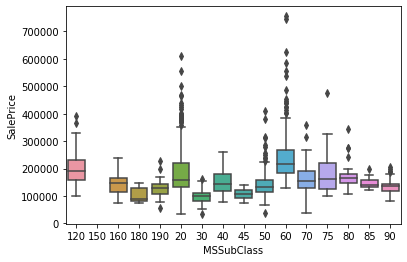

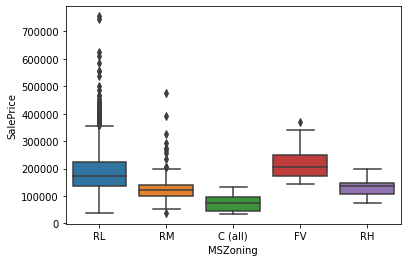

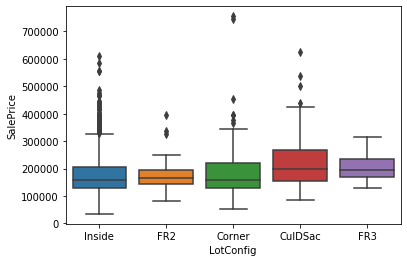

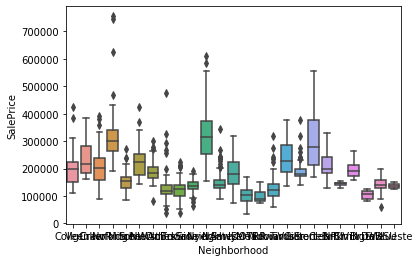

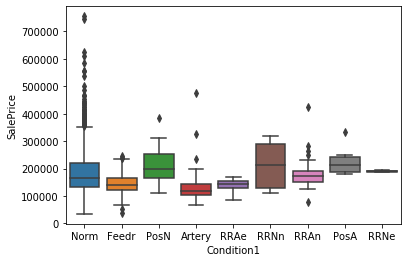

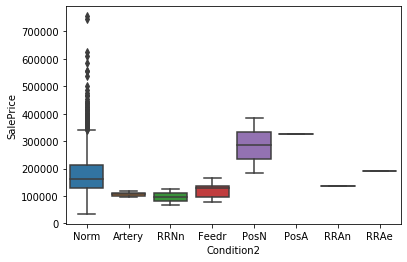

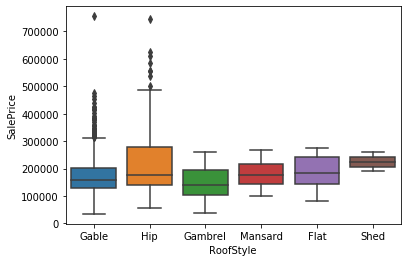

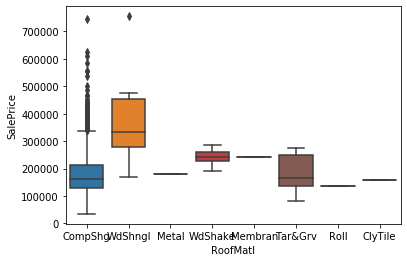

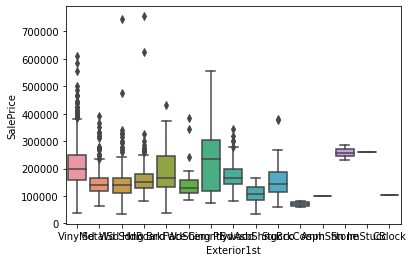

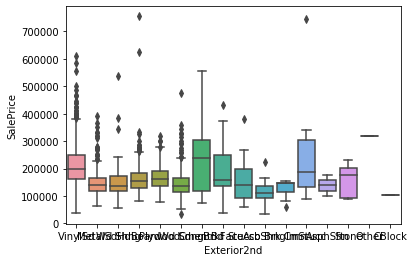

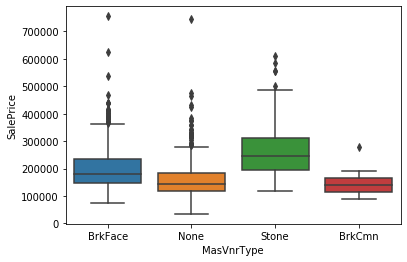

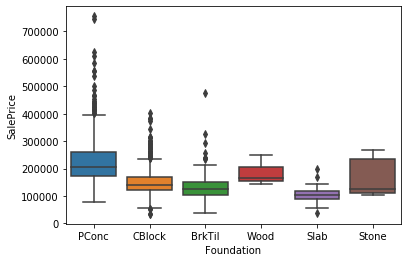

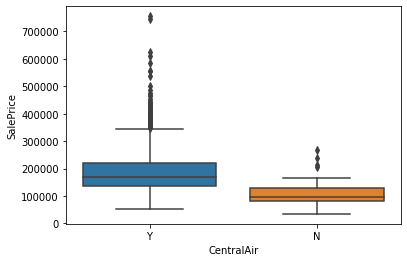

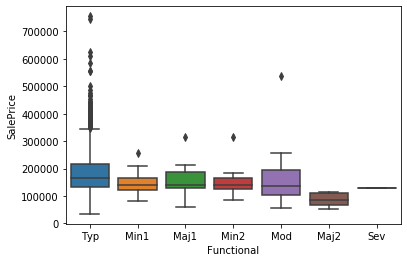

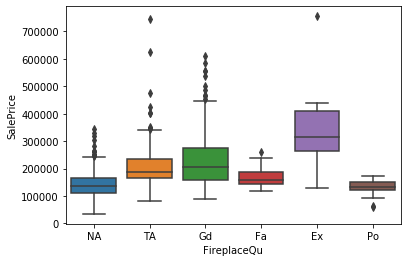

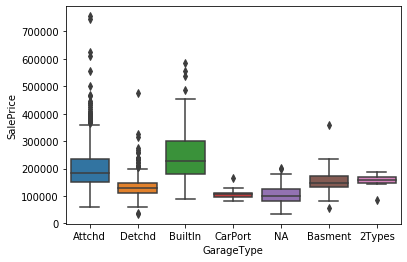

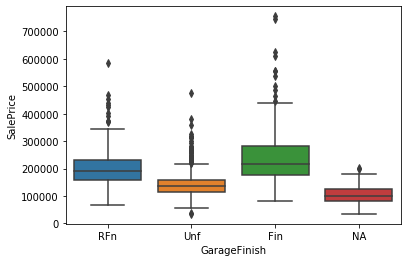

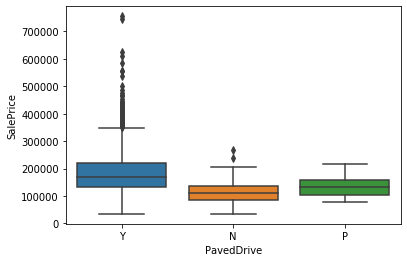

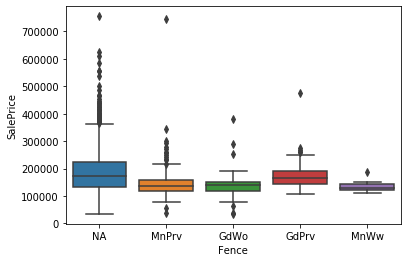

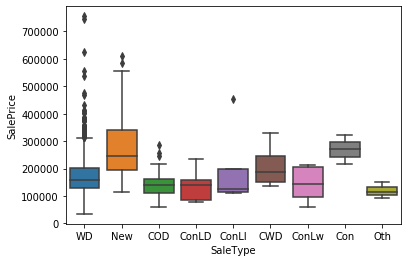

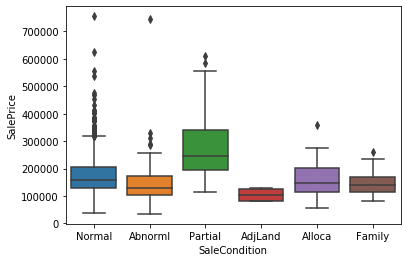

In [104]:
for i in d.columns:
    if d[i].dtype=='O':
        sns.boxplot(x=d[i],y=d['SalePrice'])
        plt.show()

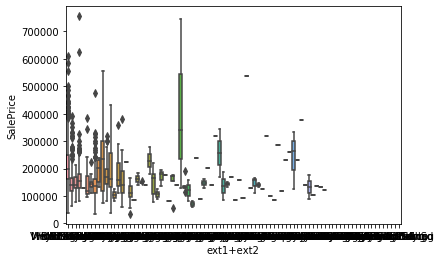

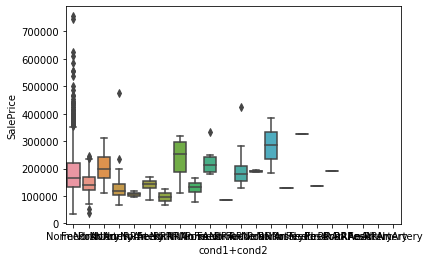

In [105]:
new=['ext1+ext2','cond1+cond2']
d['ext1+ext2']=d['Exterior1st']+d['Exterior2nd']
d['cond1+cond2']=d['Condition1']+d['Condition2']
for i in new:
    sns.boxplot(x=d[i],y=d['SalePrice'])
    plt.show()

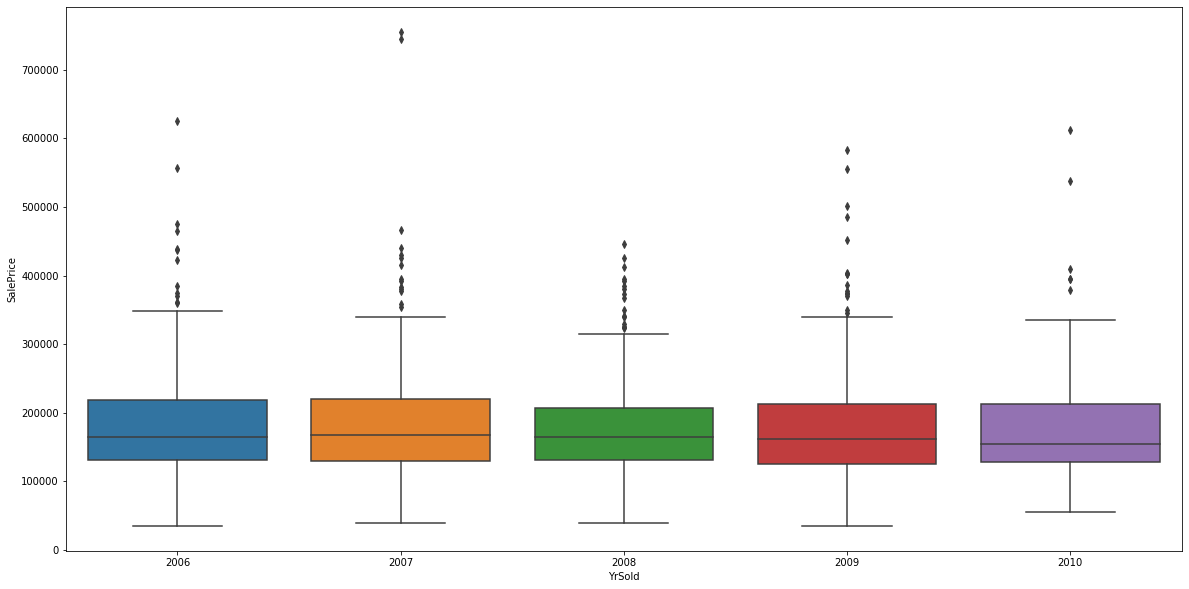

In [106]:
plt.figure(figsize=(20,10))
sns.boxplot(data=d,x='YrSold',y='SalePrice')

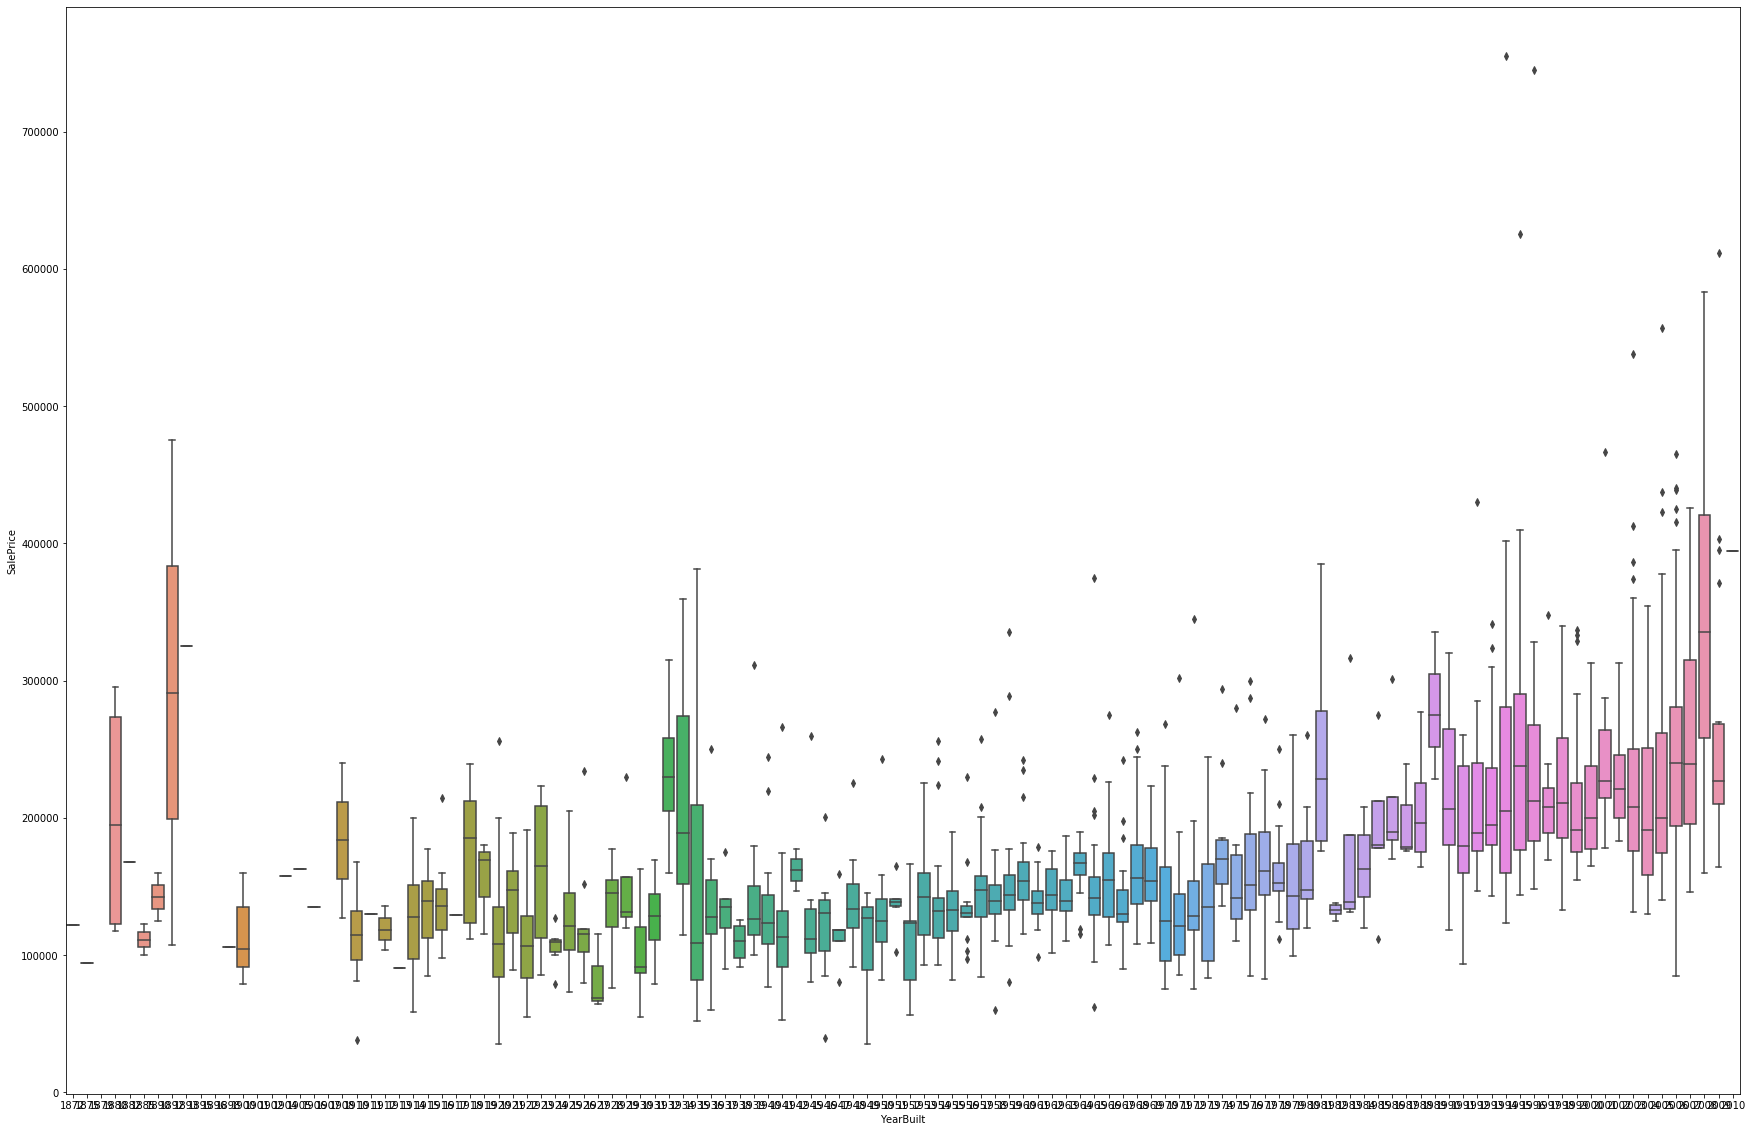

In [107]:
plt.figure(figsize=(30,20))
sns.boxplot(data=d,x='YearBuilt',y='SalePrice')

In [108]:
pd.set_option('display.max_rows',119)
d['YearBuilt'].value_counts(sort=False)

1872      1
1880      5
1882      1
1890      7
1892      2
1896      1
1898      1
1900     29
1902      1
1904      1
1906      1
1908      2
1910     43
1912      5
1914      8
1916     10
1918     10
1920     57
1922     16
1924     16
1926     19
1928      9
1930     26
1932      5
1934      5
1936     11
1938     13
1940     36
1942      6
1946     15
1948     27
1950     38
1952     18
1954     43
1956     39
1958     48
1960     37
1962     35
1964     33
1966     35
1968     45
1970     42
1972     40
1974     23
1976     54
1978     39
1980     23
1982      7
1984     19
1986     10
1988     15
1990     19
1992     27
1994     37
1996     34
1998     46
2000     48
2002     47
2004     99
2006    138
2008     49
2010      3
1875      1
1879      1
1885      2
1893      1
1895      3
1901      2
1905      3
1907      1
1911      1
1913      1
1915     24
1917      3
1919      5
1921     11
1923     17
1925     34
1927      9
1929      8
1931      7
1935     13
1937      9
1939

In [109]:
def yr_blt(x):
    if x<1901:
        return '1800s'
    elif x<1950:
        return '1900-50s'
    elif x<1960:
        return '1950s'
    elif x<1970:
        return '1960s'
    elif x<1980:
        return '1970s'
    elif x<1990:
        return '1980s'
    elif x<2000:
        return '1990s'
    elif x<2020:
        return '2000s'
d['year_built']=d['YearBuilt'].apply(yr_blt)
d['year_built'].value_counts()

2000s       783
1900-50s    577
1970s       361
1960s       357
1950s       340
1990s       332
1980s       114
1800s        55
Name: year_built, dtype: int64

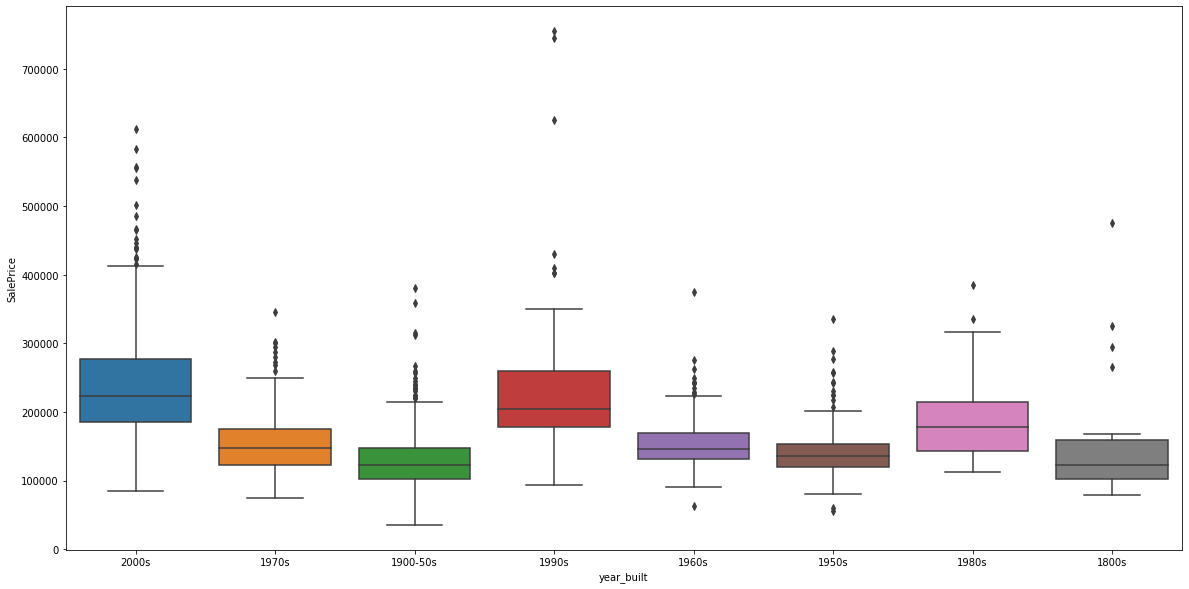

In [110]:
plt.figure(figsize=(20,10))
sns.boxplot(data=d,x='year_built',y='SalePrice')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]), <a list of 40 Text xticklabel objects>)

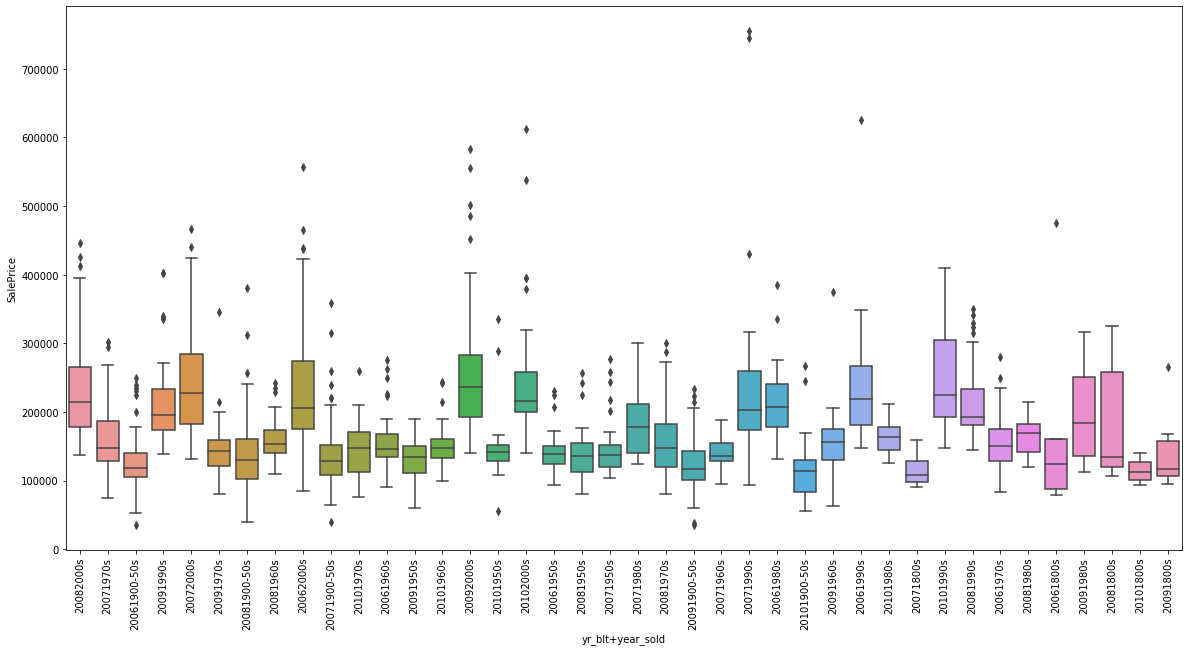

In [111]:
d['yr_blt+year_sold']=d['YrSold'].astype(str)+d['year_built']
plt.figure(figsize=(20,10))
sns.boxplot(data=d,x='yr_blt+year_sold',y='SalePrice')
plt.xticks(rotation=90)

In [112]:
d=d.drop(['YearBuilt','yr_blt+year_sold'],axis=1)

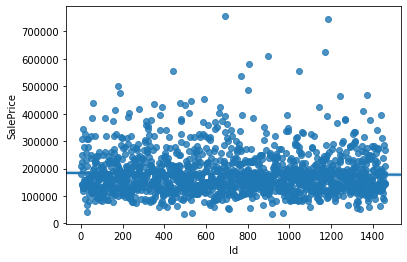

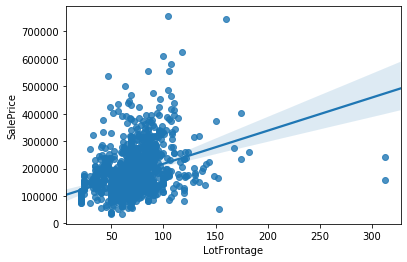

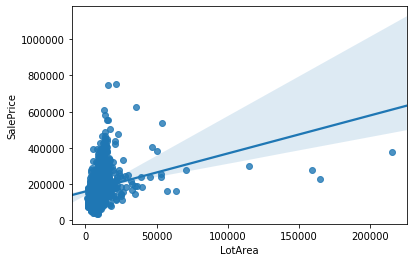

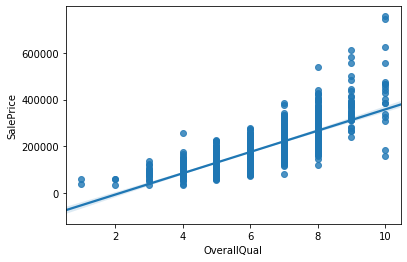

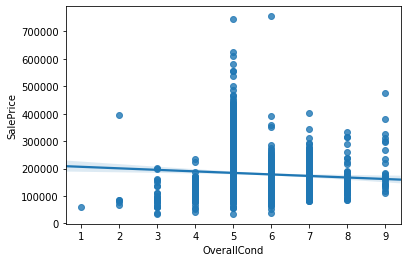

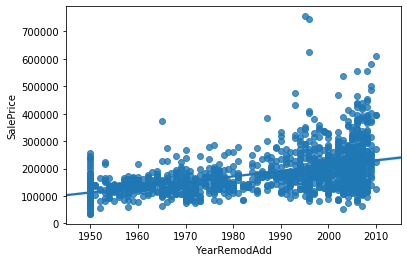

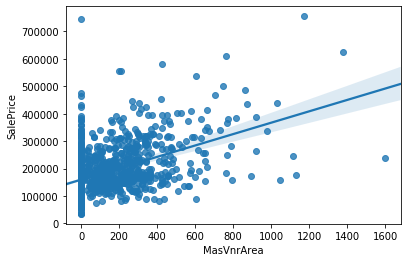

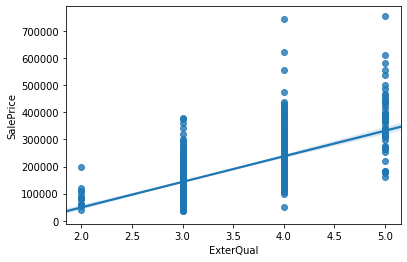

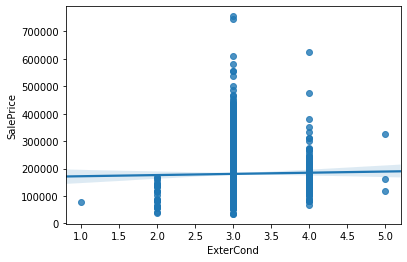

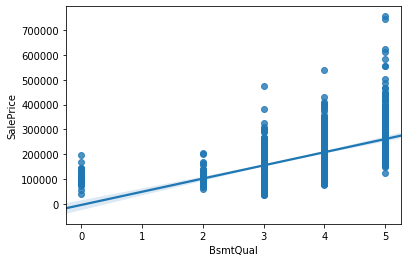

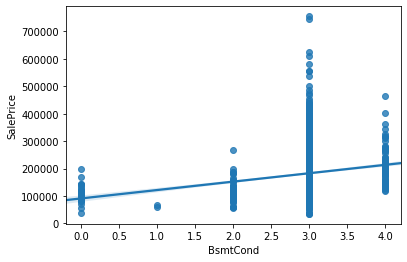

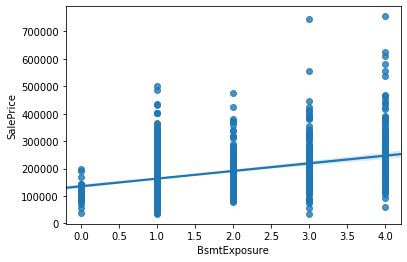

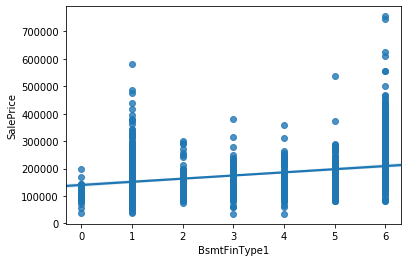

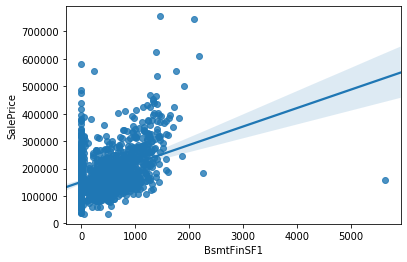

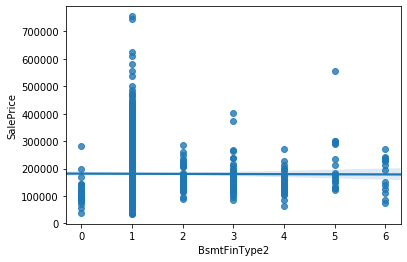

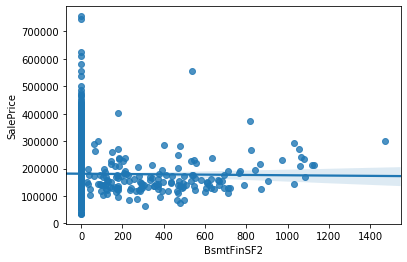

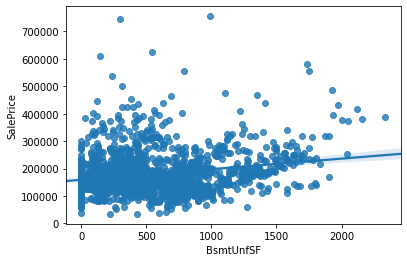

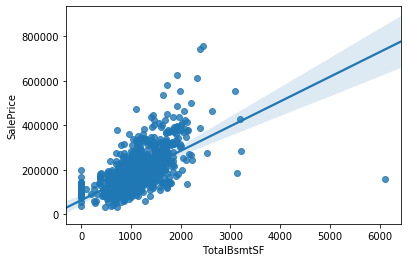

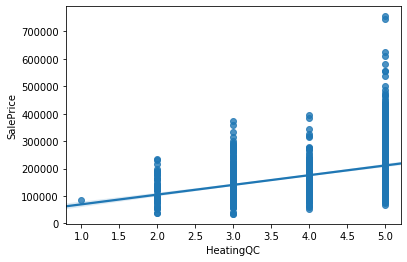

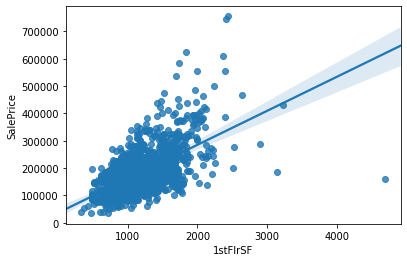

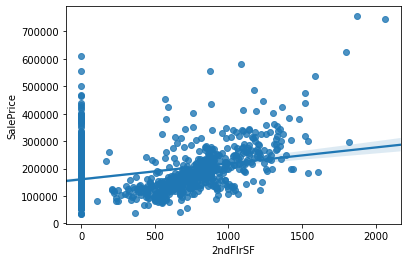

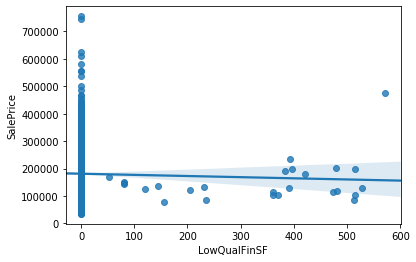

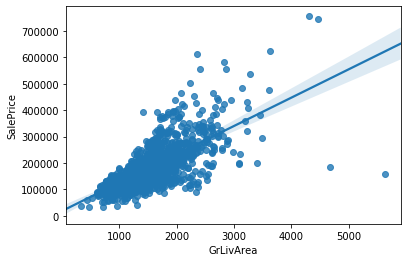

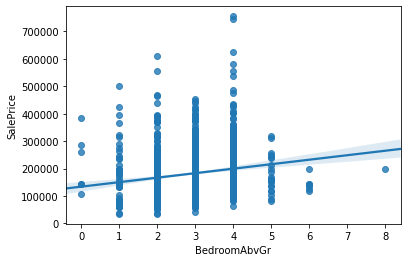

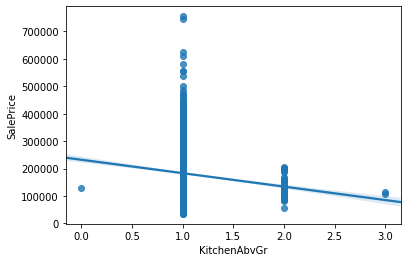

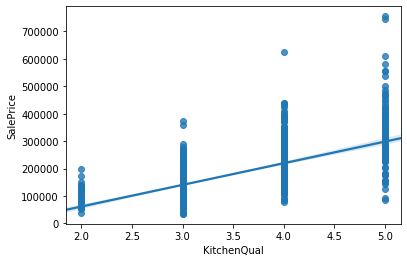

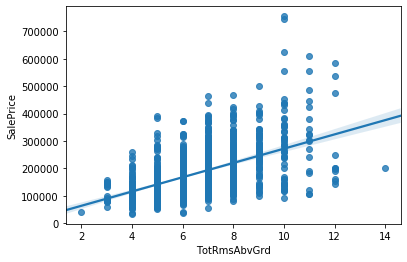

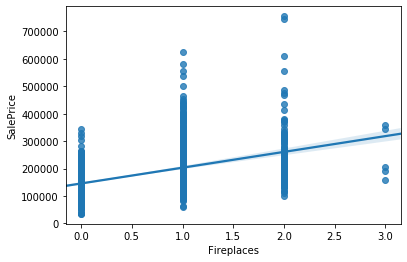

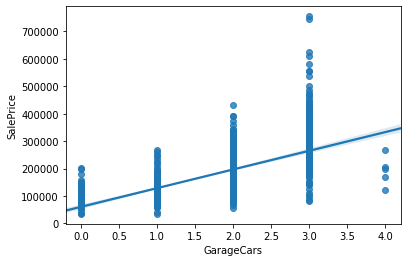

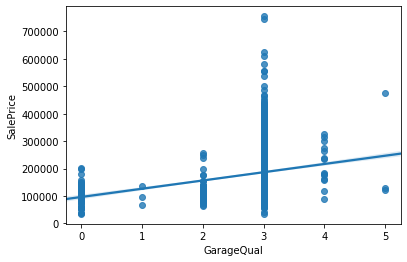

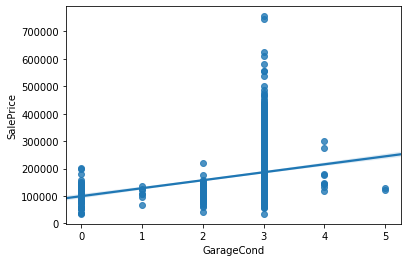

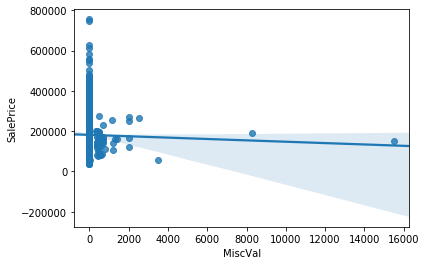

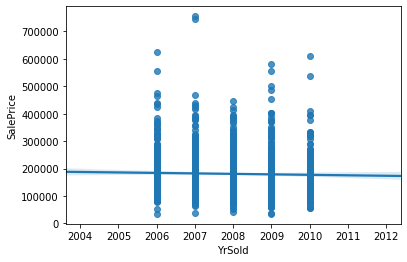

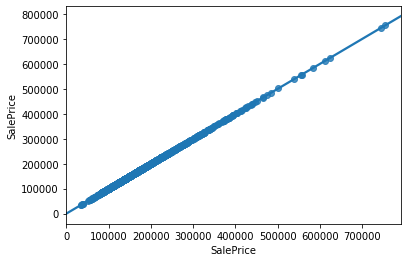

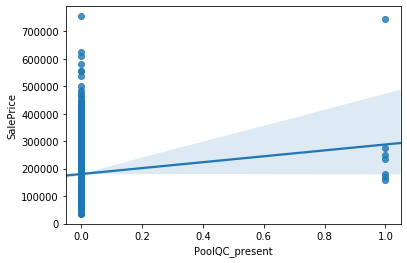

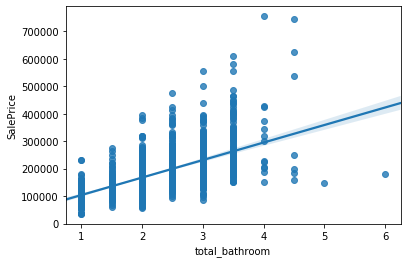

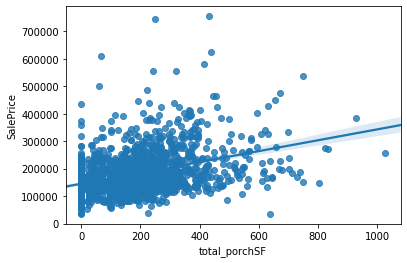

In [113]:
for i in d.columns:
    if d[i].dtype!='O':
        sns.regplot(x=d[i],y=d['SalePrice'])
        plt.show()

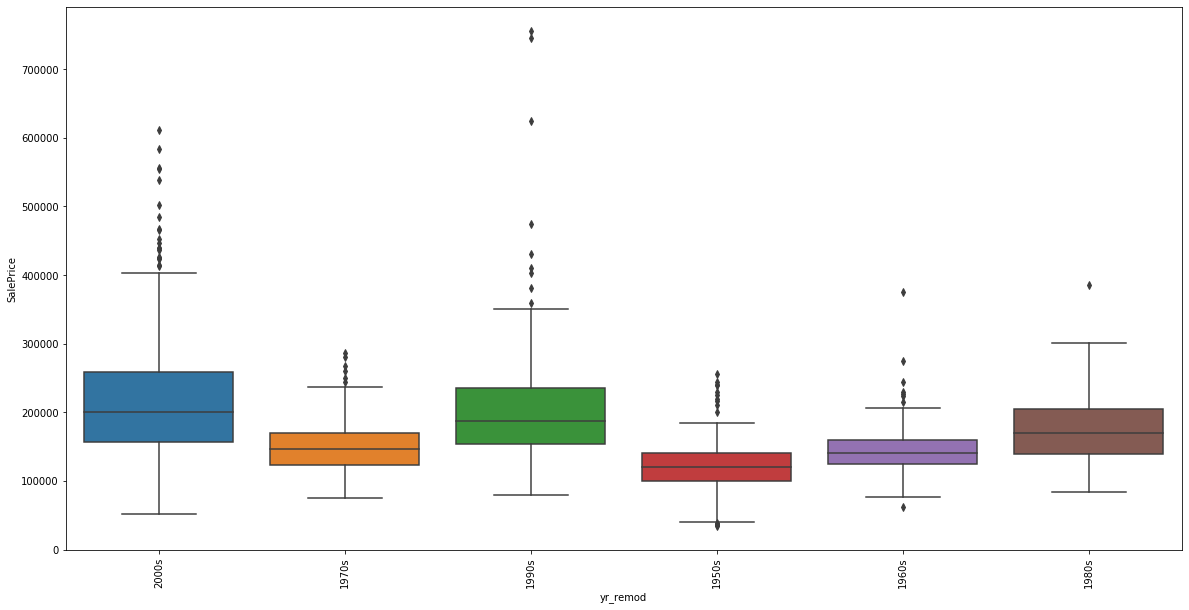

In [114]:
d['yr_remod']=d['YearRemodAdd'].apply(yr_blt)
plt.figure(figsize=(20,10))
sns.boxplot(data=d,x='yr_remod',y='SalePrice')
plt.xticks(rotation=90)
d=d.drop('YearRemodAdd',axis=1)

In [115]:
#df[dummy_cols[3]].value_counts()
dummy_cols

['PoolQC', 'MiscFeature', 'Alley']

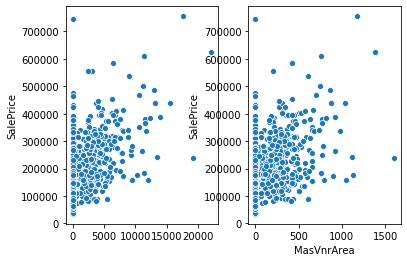

In [116]:
p=(d['MasVnrArea']*d['ExterCond']*d['ExterQual'])
fig,[ax1,ax2]=plt.subplots(1,2)
sns.scatterplot(x=p,y=d['SalePrice'],ax=ax1)

sns.scatterplot(x=(d['MasVnrArea']),y=d['SalePrice'],ax=ax2)


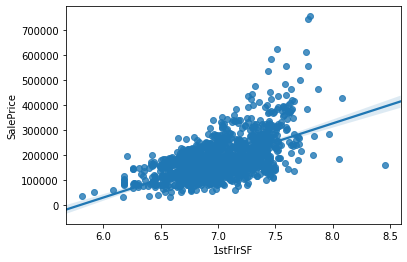

In [117]:
sns.regplot(x=np.log(d['1stFlrSF']),y=d['SalePrice'])


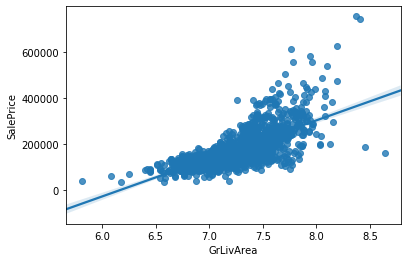

In [118]:
sns.regplot(x=np.log(d['GrLivArea']),y=d['SalePrice'])
d=d.drop('KitchenAbvGr',axis=1)


In [119]:
d=d.drop('PoolQC_present',axis=1)

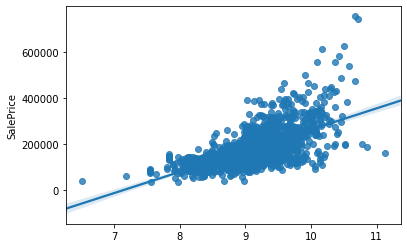

In [120]:
sns.regplot(x=np.log(d['GrLivArea']*d['TotRmsAbvGrd']),y=d['SalePrice'])

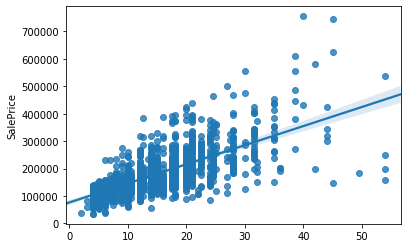

In [121]:
sns.regplot(x=(d['total_bathroom']*d['TotRmsAbvGrd']),y=d['SalePrice'])

Try a model with rooms * bathrooms ,Grlivarea * totrooms

In [122]:
d=d.drop(['ext1+ext2','cond1+cond2'],axis=1)
d['YrSold']=d['YrSold'].astype(str)
obj=[i for i in d.columns if d[i].dtype=='O']

d_final=pd.get_dummies(d,columns=obj,drop_first=True)
d_final.shape

(2919, 200)

In [123]:
train=d_final[d_final.SalePrice.isnull()==False].drop('Id',axis=1)
test=d_final[d_final.SalePrice.isnull()==True].drop(['Id','SalePrice'],axis=1)
test_id=d_final[d_final.SalePrice.isnull()==True]['Id']

In [124]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from statsmodels.api import OLS,add_constant

In [125]:
x=train.drop('SalePrice',axis=1)
y=train['SalePrice']
lr=LinearRegression()
lgb=LGBMRegressor()
lasso=Lasso(alpha=0.3,max_iter=10e6)
rf=RandomForestRegressor()

In [126]:
x_tr,x_ts,y_tr,y_ts=train_test_split(x,y,test_size=0.3,random_state=6969)
models={'Linear Regression':lr,'Random Forest':rf,'Light GBM':lgb,'Lasso':lasso}
mod1={}
for i in models:
    print('\n',i)
    a=models[i].fit(x_tr,y_tr)
    pred_ts=a.predict(x_ts)
    pred_tr=a.predict(x_tr)
    print('\nTrain Scores')
    tr_r2=r2_score(y_tr,pred_tr)
    tr_mae=mean_absolute_error(y_tr,pred_tr)
    tr_mse=mean_squared_error(y_tr,pred_tr)
    print('R2:',tr_r2)
    print('MAE:',tr_mae)
    print('MSE:',tr_mse)
    print('\nTest Scores')
    ts_r2=r2_score(y_ts,pred_ts)
    ts_mae=mean_absolute_error(y_ts,pred_ts)
    ts_mse=mean_squared_error(y_ts,pred_ts)
    print('R2:',ts_r2)
    print('MAE:',ts_mae)
    print('MSE:',ts_mse)
    mod1[i]=a


 Linear Regression

Train Scores
R2: 0.9316117347417526
MAE: 14881.61123616735
MSE: 444441167.0443527

Test Scores
R2: 0.5972537683743908
MAE: 22306.490382270717
MSE: 2351402849.8773174

 Random Forest

Train Scores
R2: 0.9813235886706917
MAE: 6544.702035225049
MSE: 121374127.79887906

Test Scores
R2: 0.8494219860566927
MAE: 18196.25833333333
MSE: 879138135.4110355

 Light GBM

Train Scores
R2: 0.9741962110236143
MAE: 5324.7213480765395
MSE: 167693478.45751977

Test Scores
R2: 0.8457134948486653
MAE: 17323.767646591918
MSE: 900789875.6647019

 Lasso

Train Scores
R2: 0.9316094791352894
MAE: 14884.143831833371
MSE: 444455825.76343477

Test Scores
R2: 0.6016925332530932
MAE: 22224.36721401991
MSE: 2325487463.0502625


In [127]:
x3_tr,x3_ts,y3_tr,y3_ts=train_test_split(x,np.log(y),test_size=0.3,random_state=6969)
models={'Linear Regression':lr,'Random Forest':rf,'Light GBM':lgb,'Lasso':lasso}
mod3={}
for i in models:
    print('\n',i)
    a=models[i].fit(x3_tr,y3_tr)
    pred_ts=a.predict(x3_ts)
    pred_tr=a.predict(x3_tr)
    print('\nTrain Scores')
    tr_r2=r2_score(y3_tr,pred_tr)
    tr_mae=mean_absolute_error(y3_tr,pred_tr)
    tr_mse=mean_squared_error(y3_tr,pred_tr)
    print('R2:',tr_r2)
    print('MAE:',tr_mae)
    print('MSE:',tr_mse)
    print('\nTest Scores')
    ts_r2=r2_score(y3_ts,pred_ts)
    ts_mae=mean_absolute_error(y3_ts,pred_ts)
    ts_mse=mean_squared_error(y3_ts,pred_ts)
    print('R2:',ts_r2)
    print('MAE:',ts_mae)
    print('MSE:',ts_mse)
    mod3[i]=a


 Linear Regression

Train Scores
R2: 0.9513045068898499
MAE: 0.06242077134358282
MSE: 0.00758015099579694

Test Scores
R2: 0.7546649900463904
MAE: 0.1038380025426362
MSE: 0.041102876401676605

 Random Forest

Train Scores
R2: 0.981332006943945
MAE: 0.0361243718645798
MSE: 0.002905940511441096

Test Scores
R2: 0.8568006357149633
MAE: 0.1025051652300789
MSE: 0.02399129978277252

 Light GBM

Train Scores
R2: 0.9876332978422905
MAE: 0.02516232248327123
MSE: 0.0019250543261455642

Test Scores
R2: 0.8783801025173728
MAE: 0.09286522076433726
MSE: 0.020375924394803076

 Lasso

Train Scores
R2: 0.6933427274730826
MAE: 0.16142054412841533
MSE: 0.047735596895080334

Test Scores
R2: 0.4708376449680127
MAE: 0.17647084473715996
MSE: 0.08865467215385453


In [128]:
np.exp( 0.092229167556607)

1.0966161021197596

In [129]:
fm=lgb.fit(x,np.log(y))
pred=fm.predict(test)
p=np.exp(pred)
result=pd.DataFrame({'SalePrice':p},index=test_id)
result.to_csv('result2_lgb.csv')


# PCA


In [130]:
from sklearn.decomposition import PCA
evr=[]
nc=[]
ss=StandardScaler()
xs=ss.fit_transform(x)
for i in tqdm(range(1,xs.shape[1])):
    pca=PCA(n_components=i)
    pca.fit(xs)
    ev=pca.explained_variance_ratio_
    evr.append(ev.sum())
    nc.append(i)
pc_cvr=pd.DataFrame(evr,index=nc,columns=['CVR'])


100%|██████████| 197/197 [00:10<00:00, 18.70it/s]


In [131]:
pc_cvr[pc_cvr['CVR']<0.9999]

,CVR
1,0.072859
2,0.110719
3,0.137628
4,0.161262
5,0.183728
...,...
184,0.999624
185,0.999699
186,0.999760
187,0.999815


In [133]:
xtr,xts,y_tr,y_ts=train_test_split(x,np.log(y),test_size=0.3,random_state=6969)
xtr=ss.fit_transform(xtr)
xts=ss.transform(xts)

pca100=PCA(n_components=100)
pca188=PCA(n_components=188)

xtr_pca100=pca100.fit_transform(xtr)
xtr_pca188=pca188.fit_transform(xtr)


xts_pca100=pca100.transform(xts)
xts_pca188=pca188.transform(xts)

pc=[[xtr_pca100,xts_pca100,100],[xtr_pca188,xts_pca188,188]]

In [134]:
#x_tr,x_ts,y_tr,y_ts=train_test_split(x,y,test_size=0.3,random_state=6969)
models={'Linear Regression':lr,'Random Forest':rf,'Light GBM':lgb,'Lasso':lasso}

for i in models:
    print('\n',i)
    for x_tr,x_ts,c in pc:
    
        print('\n N components=',c)
        a=models[i].fit(x_tr,y_tr)
        pred_ts=a.predict(x_ts)
        pred_tr=a.predict(x_tr)
        print('\nTrain Scores')
        tr_r2=r2_score(y_tr,pred_tr)
        tr_mae=mean_absolute_error(y_tr,pred_tr)
        tr_mse=mean_squared_error(y_tr,pred_tr)
        print('R2:',tr_r2)
        print('MAE:',tr_mae)
        print('MSE:',tr_mse)
        print('\nTest Scores')
        ts_r2=r2_score(y_ts,pred_ts)
        ts_mae=mean_absolute_error(y_ts,pred_ts)
        ts_mse=mean_squared_error(y_ts,pred_ts)
        print('R2:',ts_r2)
        print('MAE:',ts_mae)
        print('MSE:',ts_mse)



 Linear Regression

 N components= 100

Train Scores
R2: 0.9258677659974213
MAE: 0.07822869393178644
MSE: 0.011539744060588839

Test Scores
R2: 0.789826136817854
MAE: 0.11205676998864911
MSE: 0.03521205686409021

 N components= 188

Train Scores
R2: 0.9513044513801895
MAE: 0.06242058008808006
MSE: 0.00758015963667068

Test Scores
R2: -4.734793951271793e+20
MAE: 752455482.3189727
MSE: 7.932567414790496e+19

 Random Forest

 N components= 100

Train Scores
R2: 0.9802269712734375
MAE: 0.0388725913065053
MSE: 0.00307795514160904

Test Scores
R2: 0.8182465823124133
MAE: 0.11516171318650169
MSE: 0.030450559274878025

 N components= 188

Train Scores
R2: 0.9804042279527501
MAE: 0.03969460559921806
MSE: 0.003050362600525962

Test Scores
R2: 0.8145814953685704
MAE: 0.1175118855247163
MSE: 0.031064599707520162

 Light GBM

 N components= 100

Train Scores
R2: 0.99629197744022
MAE: 0.012402669274555595
MSE: 0.0005772068235426619

Test Scores
R2: 0.8328644162576039
MAE: 0.11286557273637683
MSE: 0

In [ ]:
d.info()